# Clasificación de señales de fugas con SVM usando escalogramas CWT promediados

## 1. Importación de bibliotecas


In [3]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import json
import os
from pathlib import Path

# Bibliotecas de scikit-learn para machine learning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuración de visualización
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.titlesize'] = 14

## 2. Definición de funciones de carga y procesamiento del dataset


In [4]:
def load_cwt_averaged_dataset(file_path):
    """
    Carga el dataset de características CWT promediadas desde un archivo H5.
    
    Args:
        file_path: Ruta al archivo H5
        
    Returns:
        dataset: Diccionario con los datos
    """
    with h5py.File(file_path, 'r') as hf:
        # Cargar características y etiquetas
        x_train = np.array(hf['train']['features'])
        y_train = np.array(hf['train']['labels'])
        
        x_test = np.array(hf['test']['features'])
        y_test = np.array(hf['test']['labels'])
        
        # Cargar metadatos
        num_classes = hf['metadata']['num_classes'][()]
        num_features = hf['metadata']['num_features'][()]
        
        # Cargar diccionario de etiquetas
        label_codes_dict = json.loads(hf['metadata'].attrs['label_codes_dict'])
    
    print(f"Dataset cargado exitosamente:")
    print(f"- Características de entrenamiento: {x_train.shape}")
    print(f"- Características de prueba: {x_test.shape}")
    print(f"- Número de clases: {num_classes}")
    print(f"- Número de características: {num_features}")
    
    dataset = {
        'x_train': x_train,
        'y_train': y_train,
        'x_test': x_test,
        'y_test': y_test,
        'num_classes': num_classes,
        'num_features': num_features,
        'label_codes_dict': label_codes_dict
    }
    
    return dataset

# 3. Análisis exploratorio de datos

In [5]:
def explore_data(dataset):
    """
    Realiza un análisis exploratorio básico del dataset.
    """
    # Distribución de clases
    class_names = list(dataset['label_codes_dict'].keys())
    class_codes = list(dataset['label_codes_dict'].values())
    
    # Contar muestras por clase
    train_counts = np.bincount(dataset['y_train'])
    test_counts = np.bincount(dataset['y_test'])
    
    # Crear dataframe para visualización
    df_counts = pd.DataFrame({
        'Clase': class_names,
        'Entrenamiento': [train_counts[i] for i in class_codes],
        'Prueba': [test_counts[i] for i in class_codes]
    })
    
    # Visualizar distribución
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.barplot(x='Clase', y='Entrenamiento', data=df_counts, ax=ax1)
    ax1.set_title('Distribución de clases en conjunto de entrenamiento')
    ax1.set_ylabel('Número de muestras')
    ax1.tick_params(axis='x', rotation=45)
    
    sns.barplot(x='Clase', y='Prueba', data=df_counts, ax=ax2)
    ax2.set_title('Distribución de clases en conjunto de prueba')
    ax2.set_ylabel('Número de muestras')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Visualizar ejemplos de cada clase
    class_examples = {}
    fig, axs = plt.subplots(len(class_names), 2, figsize=(12, 3*len(class_names)))
    
    # Para cada clase
    for i, class_code in enumerate(class_codes):
        # Encontrar índices de esta clase en el conjunto de entrenamiento
        indices = np.where(dataset['y_train'] == class_code)[0]
        
        if len(indices) > 0:
            # Visualizar 2 ejemplos aleatorios
            for j in range(2):
                if j < len(indices):
                    idx = indices[j]
                    axs[i, j].plot(dataset['x_train'][idx])
                    axs[i, j].set_title(f"{class_names[i]} - Ejemplo {j+1}")
                    axs[i, j].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Correlación entre características
    plt.figure(figsize=(10, 8))
    corr_matrix = np.corrcoef(dataset['x_train'].T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Matriz de correlación entre características')
    plt.show()

## 4. Construcción y entrenamiento del modelo SVM

In [6]:
def build_and_train_svm(dataset):
    """
    Construye y entrena un modelo SVM optimizado para clasificar las fugas.
    Muestra el progreso de entrenamiento en tiempo real con una barra de progreso.
    
    Args:
        dataset: Diccionario con los datos
        
    Returns:
        best_model: El modelo SVM optimizado
        scores: Resultados de la validación cruzada
    """
    from datetime import datetime
    import numpy as np
    from tqdm.notebook import tqdm  # Usar tqdm.notebook para Jupyter
    
    X_train = dataset['x_train']
    y_train = dataset['y_train']
    
    # Crear pipeline con escalado y SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    # Definir parámetros para búsqueda de grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'svm__kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    # Calcular el número total de combinaciones
    from sklearn.model_selection import ParameterGrid
    param_list = list(ParameterGrid(param_grid))
    n_combinations = len(param_list)
    print(f"Buscando entre {n_combinations} combinaciones de hiperparámetros...")
    
    # Configurar validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Preparar para almacenar resultados
    results = []
    best_score = 0
    best_params = None
    
    # Crear barra de progreso con tqdm
    progress_bar = tqdm(total=n_combinations, desc="Entrenando SVM")
    
    # Para cada combinación de parámetros
    for params in param_list:
        # Configurar el modelo con estos parámetros
        pipeline.set_params(**params)
        
        # Realizar validación cruzada
        cv_scores = []
        for train_idx, test_idx in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
            y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
            
            pipeline.fit(X_train_fold, y_train_fold)
            score = pipeline.score(X_test_fold, y_test_fold)
            cv_scores.append(score)
        
        # Calcular precisión media de validación cruzada
        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)
        
        # Guardar resultados
        result = {
            'params': params,
            'mean_score': mean_score,
            'std_score': std_score,
            'cv_scores': cv_scores
        }
        results.append(result)
        
        # Actualizar el mejor modelo si es necesario
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        
        # Actualizar descripción de la barra de progreso con el mejor resultado
        progress_bar.set_postfix({
            'mejor': f"{best_score:.4f}",
            'actual': f"{mean_score:.4f}",
            'C': params['svm__C'],
            'gamma': params['svm__gamma'],
            'kernel': params['svm__kernel']
        })
        
        # Avanzar barra de progreso
        progress_bar.update(1)
    
    # Cerrar barra de progreso
    progress_bar.close()
    
    # Ordenar resultados por precisión
    sorted_results = sorted(results, key=lambda x: x['mean_score'], reverse=True)
    
    # Mostrar los 3 mejores resultados
    print("\nTop 3 mejores configuraciones:")
    for i, result in enumerate(sorted_results[:3]):
        params = result['params']
        mean = result['mean_score']
        std = result['std_score']
        print(f"{i+1}. Precisión: {mean:.4f} ± {std:.4f} | C={params['svm__C']}, gamma={params['svm__gamma']}, kernel={params['svm__kernel']}")
    
    # Reentrenar el modelo con los mejores parámetros
    print(f"\nReentrenando modelo con la mejor configuración...")
    pipeline.set_params(**best_params)
    pipeline.fit(X_train, y_train)
    
    return pipeline, sorted_results

## 5. Evaluación del modelo

In [7]:
def evaluate_model(model, dataset):
    """
    Evalúa el rendimiento del modelo en el conjunto de prueba.
    
    Args:
        model: Modelo SVM entrenado
        dataset: Diccionario con los datos
    """
    X_test = dataset['x_test']
    y_test = dataset['y_test']
    class_names = list(dataset['label_codes_dict'].keys())
    
    # Predecir en conjunto de prueba
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Rendimiento en conjunto de prueba:")
    print(f"Precisión global: {accuracy:.4f}")
    
    # Reporte de clasificación
    print("\nReporte de clasificación detallado:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Matriz de confusión
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalizar matriz para mejor visualización
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión Normalizada')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Visualizar algunas predicciones
    n_samples = 10
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.plot(X_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 6. Análisis de importancia de características


In [8]:
def analyze_feature_importance(model, dataset):
    """
    Analiza la importancia de cada característica para la clasificación.
    
    Args:
        model: Modelo SVM entrenado
        dataset: Diccionario con los datos
    """
    X_train = dataset['x_train']
    
    # Solo funciona con kernel lineal
    if model.named_steps['svm'].kernel == 'linear':
        # Obtener los coeficientes del SVM
        coefs = model.named_steps['svm'].coef_
        
        # Promediar la importancia absoluta de cada característica entre todas las clases
        importances = np.mean(np.abs(coefs), axis=0)
        
        # Visualizar importancias
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(importances)), importances)
        plt.title('Importancia de características (coeficientes SVM)')
        plt.xlabel('Índice de escala')
        plt.ylabel('Importancia relativa')
        plt.grid(True)
        plt.show()
    else:
        # Para kernels no lineales, usar enfoque basado en permutación
        from sklearn.inspection import permutation_importance
        
        # Calcular importancia por permutación
        print("Calculando importancia de características por permutación...")
        result = permutation_importance(
            model, X_train, dataset['y_train'], 
            n_repeats=10, random_state=42, n_jobs=-1
        )
        
        importances = result.importances_mean
        
        # Crear eje de frecuencia logarítmico (igual que en la visualización original)
        fs = 25600  # Frecuencia de muestreo
        f0 = 1.0    # Frecuencia mínima
        f1 = fs/2   # Frecuencia máxima (Nyquist)
        fn = dataset['num_features']  # Número de escalas
        freqs = np.geomspace(f1, f0, fn)
        
        # Visualizar importancia vs. frecuencia
        plt.figure(figsize=(12, 6))
        plt.semilogx(freqs, importances, 'o-')
        plt.title('Importancia de frecuencias para clasificación')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Importancia (disminución en precisión)')
        plt.grid(True)
        plt.show()
        
        # Mostrar las 5 características más importantes
        top_indices = np.argsort(importances)[::-1][:5]
        print("\nLas 5 frecuencias más importantes:")
        for i, idx in enumerate(top_indices):
            print(f"{i+1}. Escala {idx}: {freqs[idx]:.2f} Hz - Importancia: {importances[idx]:.4f}")

## 7. Guardar el modelo entrenado

In [9]:
def save_model(model, label_codes_dict, file_path='svm_cwt_averaged_model.pkl'):
    """
    Guarda el modelo entrenado junto con la información necesaria para su uso.
    
    Args:
        model: Modelo SVM entrenado
        label_codes_dict: Diccionario de etiquetas
        file_path: Ruta donde guardar el modelo
    """
    import pickle
    
    # Crear diccionario con toda la información necesaria
    model_data = {
        'model': model,
        'label_codes_dict': label_codes_dict,
        'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'SVM',
        'feature_type': 'CWT_Averaged'
    }
    
    # Guardar usando pickle
    with open(file_path, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Modelo guardado exitosamente en '{file_path}'")
    
    # Generar código de ejemplo para usar el modelo
    example_code = '''
# Código ejemplo para usar el modelo guardado:
import pickle
import numpy as np

# Cargar el modelo
with open('svm_cwt_averaged_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
label_codes_dict = model_data['label_codes_dict']

# Función para convertir señal a características
def extract_cwt_averaged_features(signal, fs=25600, segment_size=512):
    # Implementa aquí la extracción de características
    # usando fcwt.boilerplate.cwt para calcular CWT
    # y promediando temporalmente
    pass

# Ejemplo de predicción
def predict_leak_type(signal):
    # Extraer características
    features = extract_cwt_averaged_features(signal)
    
    # Realizar predicción
    prediction = model.predict([features])[0]
    
    # Obtener nombre de clase
    class_names = list(label_codes_dict.keys())
    class_codes = list(label_codes_dict.values())
    predicted_class = class_names[class_codes.index(prediction)]
    
    return predicted_class
'''
    
    # Guardar código de ejemplo
    with open('example_usage.py', 'w') as f:
        f.write(example_code)
    
    print("Código de ejemplo guardado en 'example_usage.py'")

## 8. Función principal que integra todos los componentes

=== Clasificación de fugas con SVM usando características CWT promediadas ===

Cargando dataset...
Dataset cargado exitosamente:
- Características de entrenamiento: (48000, 13)
- Características de prueba: (12000, 13)
- Número de clases: 5
- Número de características: 13

--- Análisis exploratorio de datos ---


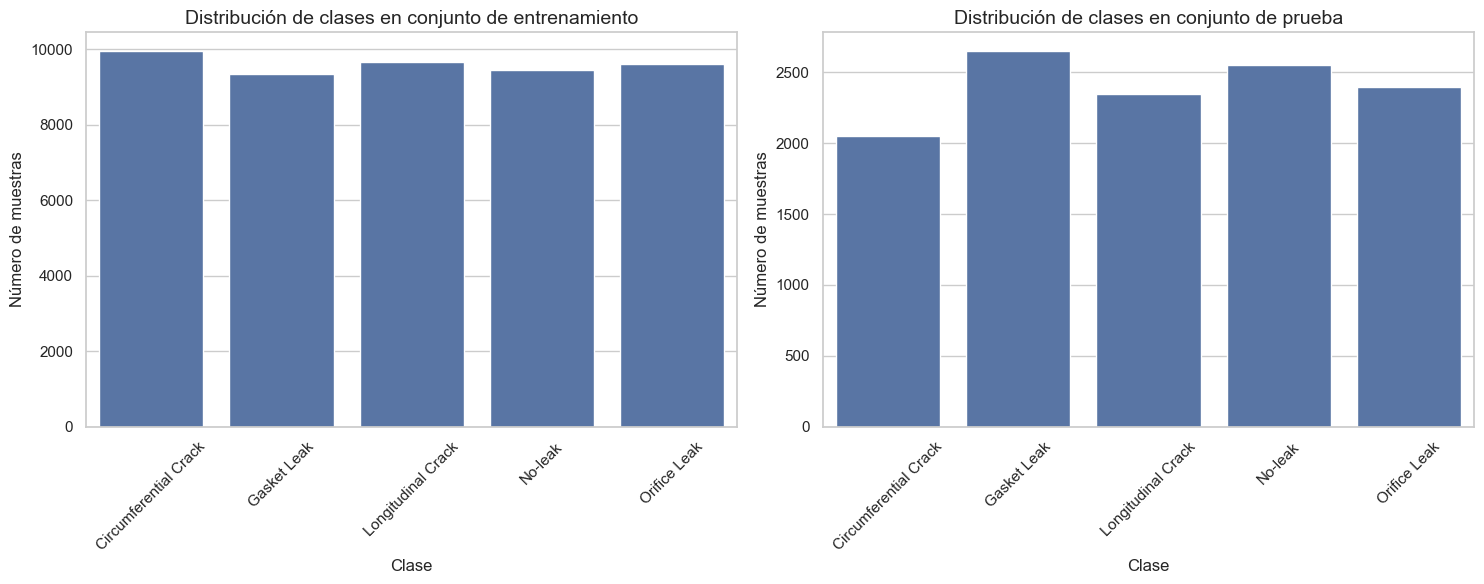

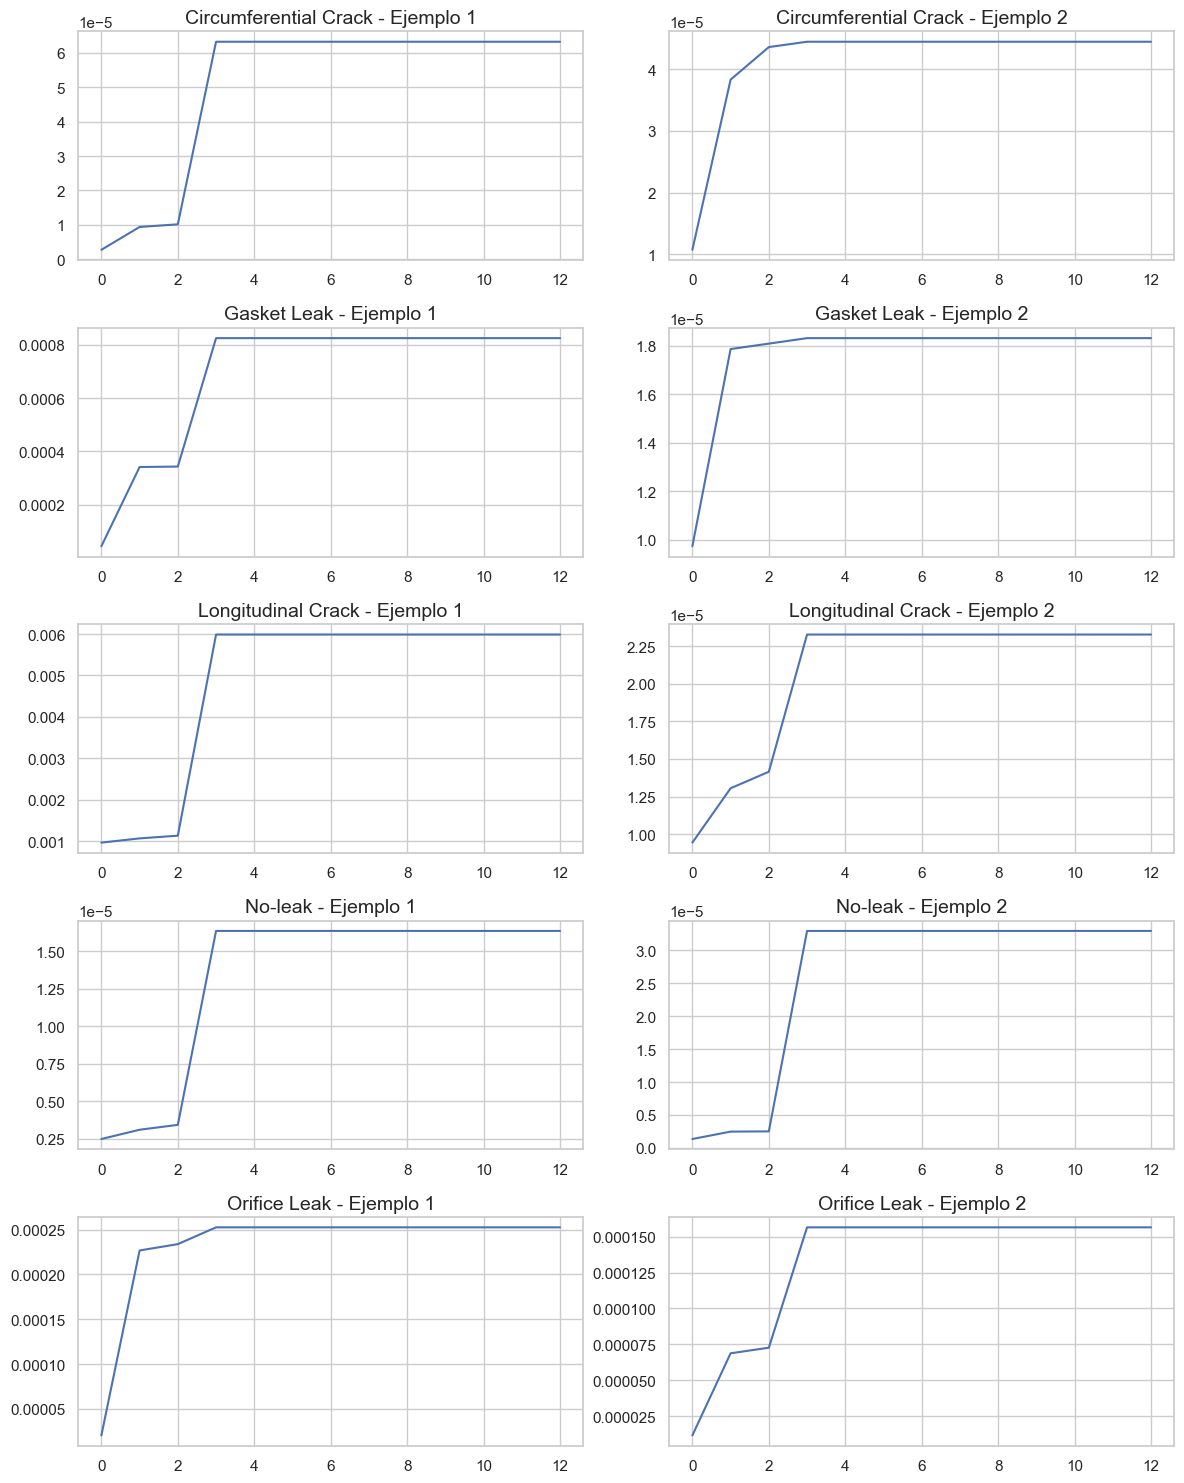

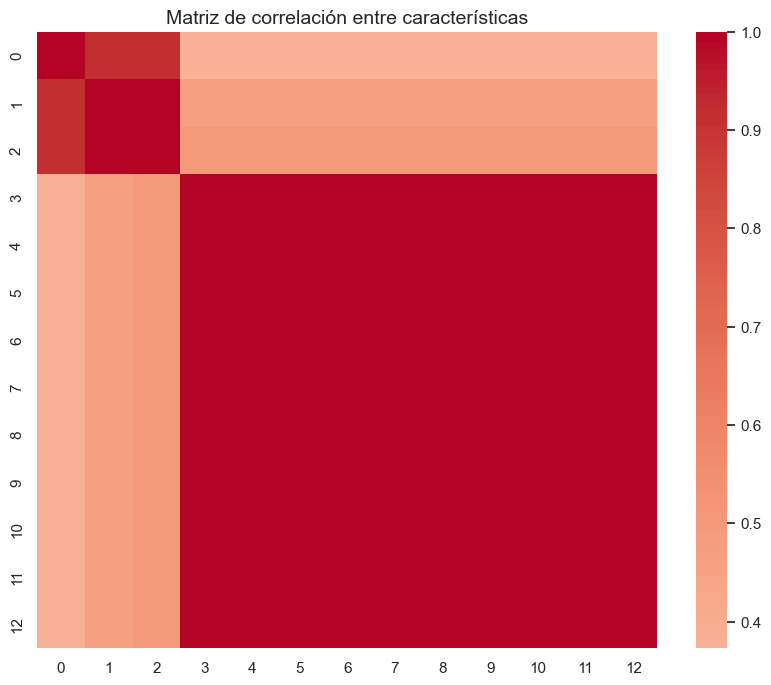


--- Entrenando modelo SVM ---
Buscando entre 60 combinaciones de hiperparámetros...


Entrenando SVM:   0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
def main():
    """
    Función principal que ejecuta todo el flujo de trabajo.
    """
    print("=== Clasificación de fugas con SVM usando características CWT promediadas ===\n")
    
    # Definir ruta al dataset
    dataset_path = 'accelerometer_cwt_averaged_ns512_processed.h5'
    
    # Verificar que el archivo exista
    if not os.path.isfile(dataset_path):
        print(f"ERROR: No se encontró el archivo '{dataset_path}'")
        print("Por favor, asegúrate de que el archivo está en el directorio correcto.")
        return
    
    # 1. Cargar datos
    print("Cargando dataset...")
    dataset = load_cwt_averaged_dataset(dataset_path)
    
    # 2. Explorar datos
    print("\n--- Análisis exploratorio de datos ---")
    explore_data(dataset)
    
    # 3. Construir y entrenar modelo
    print("\n--- Entrenando modelo SVM ---")
    model, cv_results = build_and_train_svm(dataset)
    
    # 4. Evaluar modelo
    print("\n--- Evaluando modelo en conjunto de prueba ---")
    evaluate_model(model, dataset)
    
    # 5. Analizar importancia de características
    print("\n--- Analizando importancia de características ---")
    analyze_feature_importance(model, dataset)
    
    # 6. Guardar modelo
    print("\n--- Guardando modelo entrenado ---")
    save_model(model, dataset['label_codes_dict'])
    
    print("\n=== Proyecto completado exitosamente ===")

# Ejecutar la función principal
if __name__ == "__main__":
    main()

# Modelo SVM simplificado

In [ ]:
def train_simple_svm(dataset, C=100, gamma=1):
    """
    Entrena un modelo SVM simple con parámetros fijos (sin búsqueda de hiperparámetros).
    
    Args:
        dataset: Diccionario con los datos
        C: Parámetro de regularización 
        gamma: Parámetro del kernel RBF
        
    Returns:
        model: Modelo SVM entrenado
    """
    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Separar datos
    X_train = dataset['x_train']
    y_train = dataset['y_train']
    X_test = dataset['x_test']
    y_test = dataset['y_test']
    
    # Nombres de clases para visualización
    label_codes_dict = dataset['label_codes_dict']
    class_names = list(label_codes_dict.keys())
    
    print(f"Entrenando SVM con parámetros fijos:")
    print(f"- C = {C}")
    print(f"- gamma = {gamma}")
    print(f"- kernel = rbf")
    
    # Crear pipeline con escalado y SVM
    model = Pipeline([
        ('scaler', StandardScaler()),  # Normalizar características
        ('svm', SVC(C=C, gamma=gamma, kernel='rbf', probability=True, random_state=42))
    ])
    
    # Entrenar modelo
    print("Entrenando modelo...")
    model.fit(X_train, y_train)
    
    # Evaluar en conjunto de entrenamiento
    train_preds = model.predict(X_train)
    train_acc = model.score(X_train, y_train)
    print(f"Precisión en conjunto de entrenamiento: {train_acc:.4f} ({train_acc*100:.2f}%)")
    
    # Evaluar en conjunto de prueba
    test_preds = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    print(f"Precisión en conjunto de prueba: {test_acc:.4f} ({test_acc*100:.2f}%)")
    
    # Mostrar matriz de confusión para conjunto de prueba
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, test_preds)
    
    # Normalizar matriz para mejor visualización
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='YlGnBu',
                   xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Mostrar reporte de clasificación detallado
    from sklearn.metrics import classification_report
    print("\nReporte de clasificación:")
    print(classification_report(y_test, test_preds, target_names=class_names))
    
    return model

# Ejecutar la función con diferentes valores de C y gamma para comparar
# Primero cargar el dataset (asegúrate de que esta función está definida en tu notebook)
dataset = load_cwt_averaged_dataset('accelerometer_cwt_averaged_ns512_processed.h5')

# Entrenar modelo con valores del ejemplo (ajustados para tu dataset)
model = train_simple_svm(dataset, C=100, gamma=0.1)

# Opcional: probar diferentes valores para encontrar la mejor configuración simple
print("\nProbando diferentes configuraciones:")
for C in [10, 100, 1000]:
    for gamma in [0.01, 0.1, 1]:
        print(f"\n--- C={C}, gamma={gamma} ---")
        model = train_simple_svm(dataset, C=C, gamma=gamma)

Dataset cargado exitosamente:
- Características de entrenamiento: (48000, 13)
- Características de prueba: (12000, 13)
- Número de clases: 5
- Número de características: 13
Entrenando SVM con parámetros fijos:
- C = 100
- gamma = 0.1
- kernel = rbf
Entrenando modelo...
